In [6]:
%load_ext autoreload
%autoreload 2

# PriorVAE: Search Grid for MMD params 

In [7]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [12]:
if True:
    path = "./learnt_models/09/09_args_rqk_grid.dill" 
    name_fn = lambda a,l: f"mmd_rqk_sum:{l},{a}"
    a_label = "alpha/scale"
    l_label = "lengthscale"

if False:
    path = "" 
    name_fn = None
    s_label = ""
    t_label = ""

with open(path, "rb") as f:
    args = dill.load(f)


In [13]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# Grid of training plots

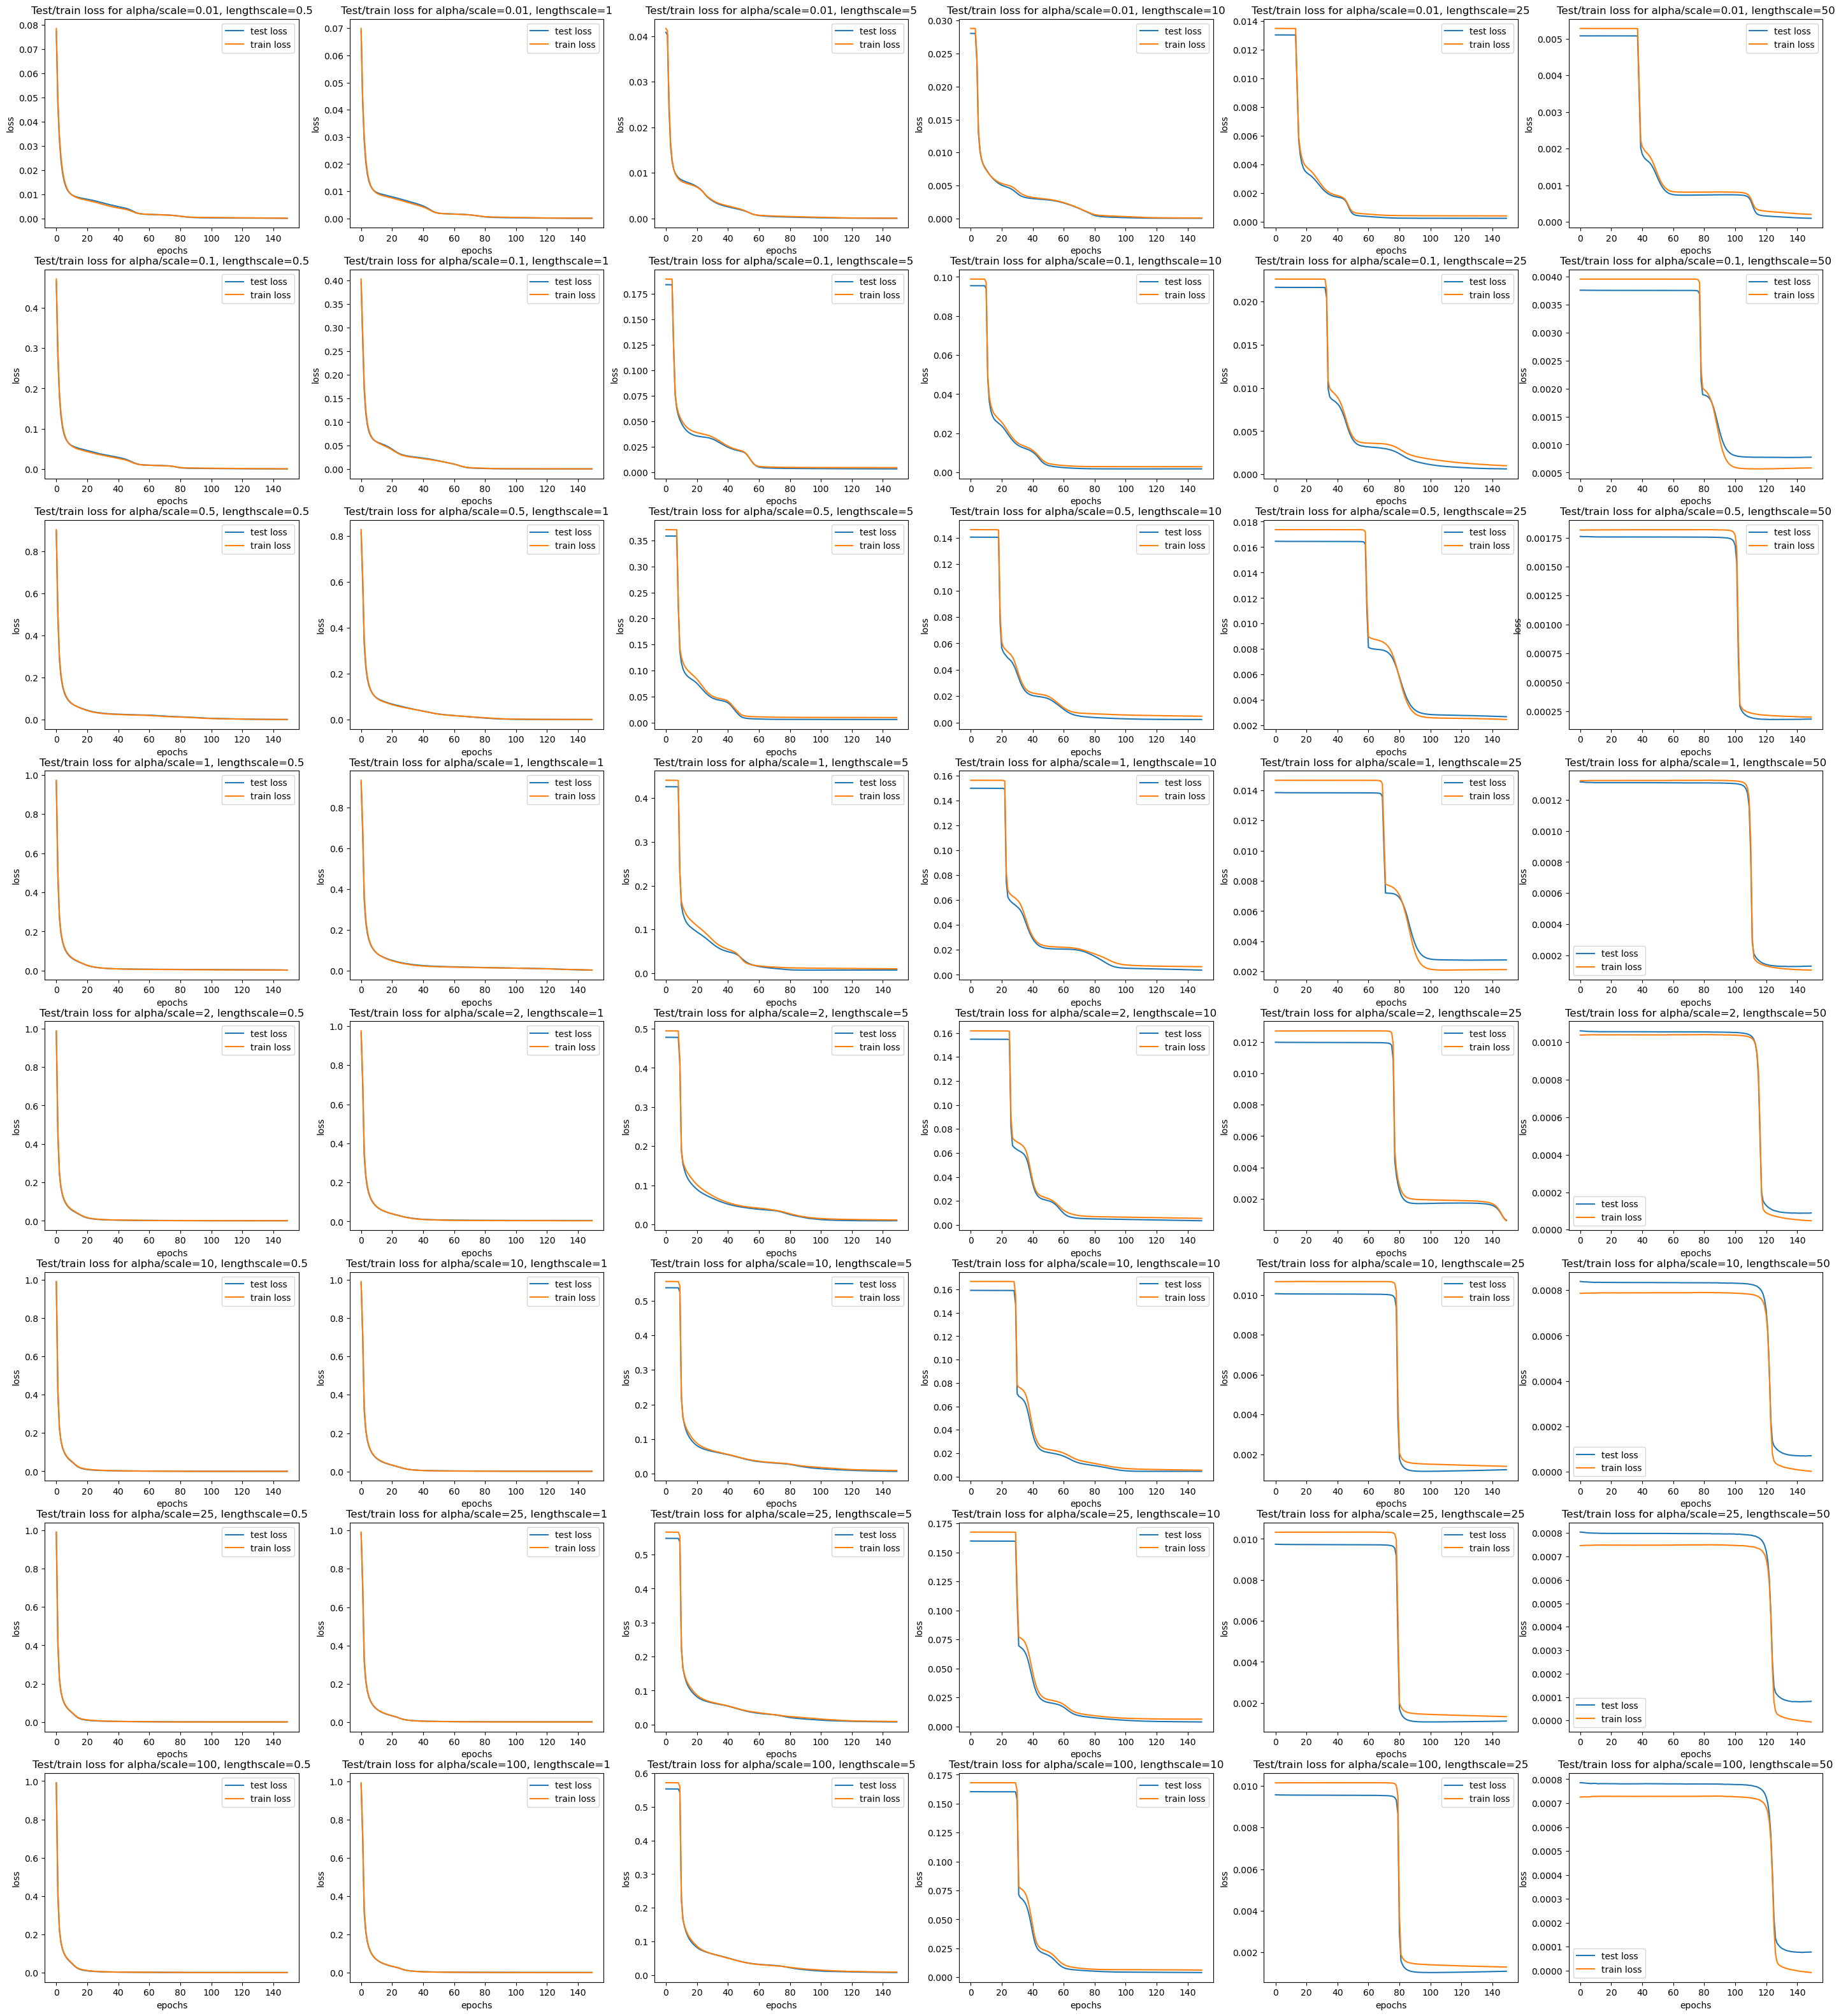

In [15]:
training_fig, training_axs = plt.subplots(nrows=len(args["a_range"]), ncols=len(args["l_range"]), figsize=(len(args["l_range"]) * 6, len(args["a_range"]) * 5))

for i, a in enumerate(args["a_range"]):
    for j, l in enumerate(args["l_range"]):
        file_path = f'{get_savepath()}/{decoder_filename("09/09", args, suffix=name_fn(a,l)+"_metrics_hist")}'
        
        try: 
            with open(file_path, 'rb') as file:
                metrics_history = dill.load(file)


            
            plot_training(
                metrics_history["test_loss"], 
                metrics_history["train_loss"], 
                f"Test/train loss for {a_label}={a}, {l_label}={l}",
                "loss",
                training_axs[i,j]
            )

        except FileNotFoundError:
            print(f"Failed to load a={a}, l={l}, path = {file_path}")

# Grid of comparison plots

Versus:


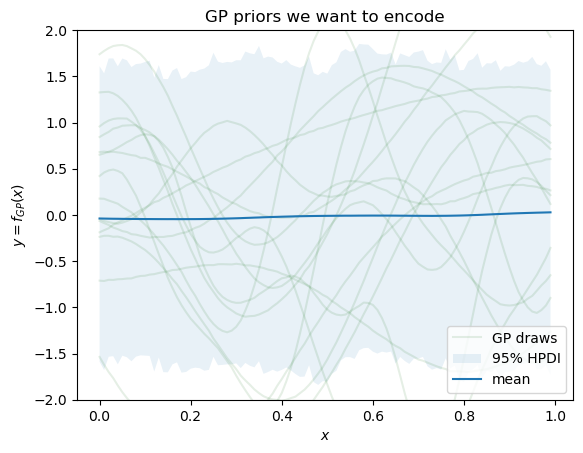

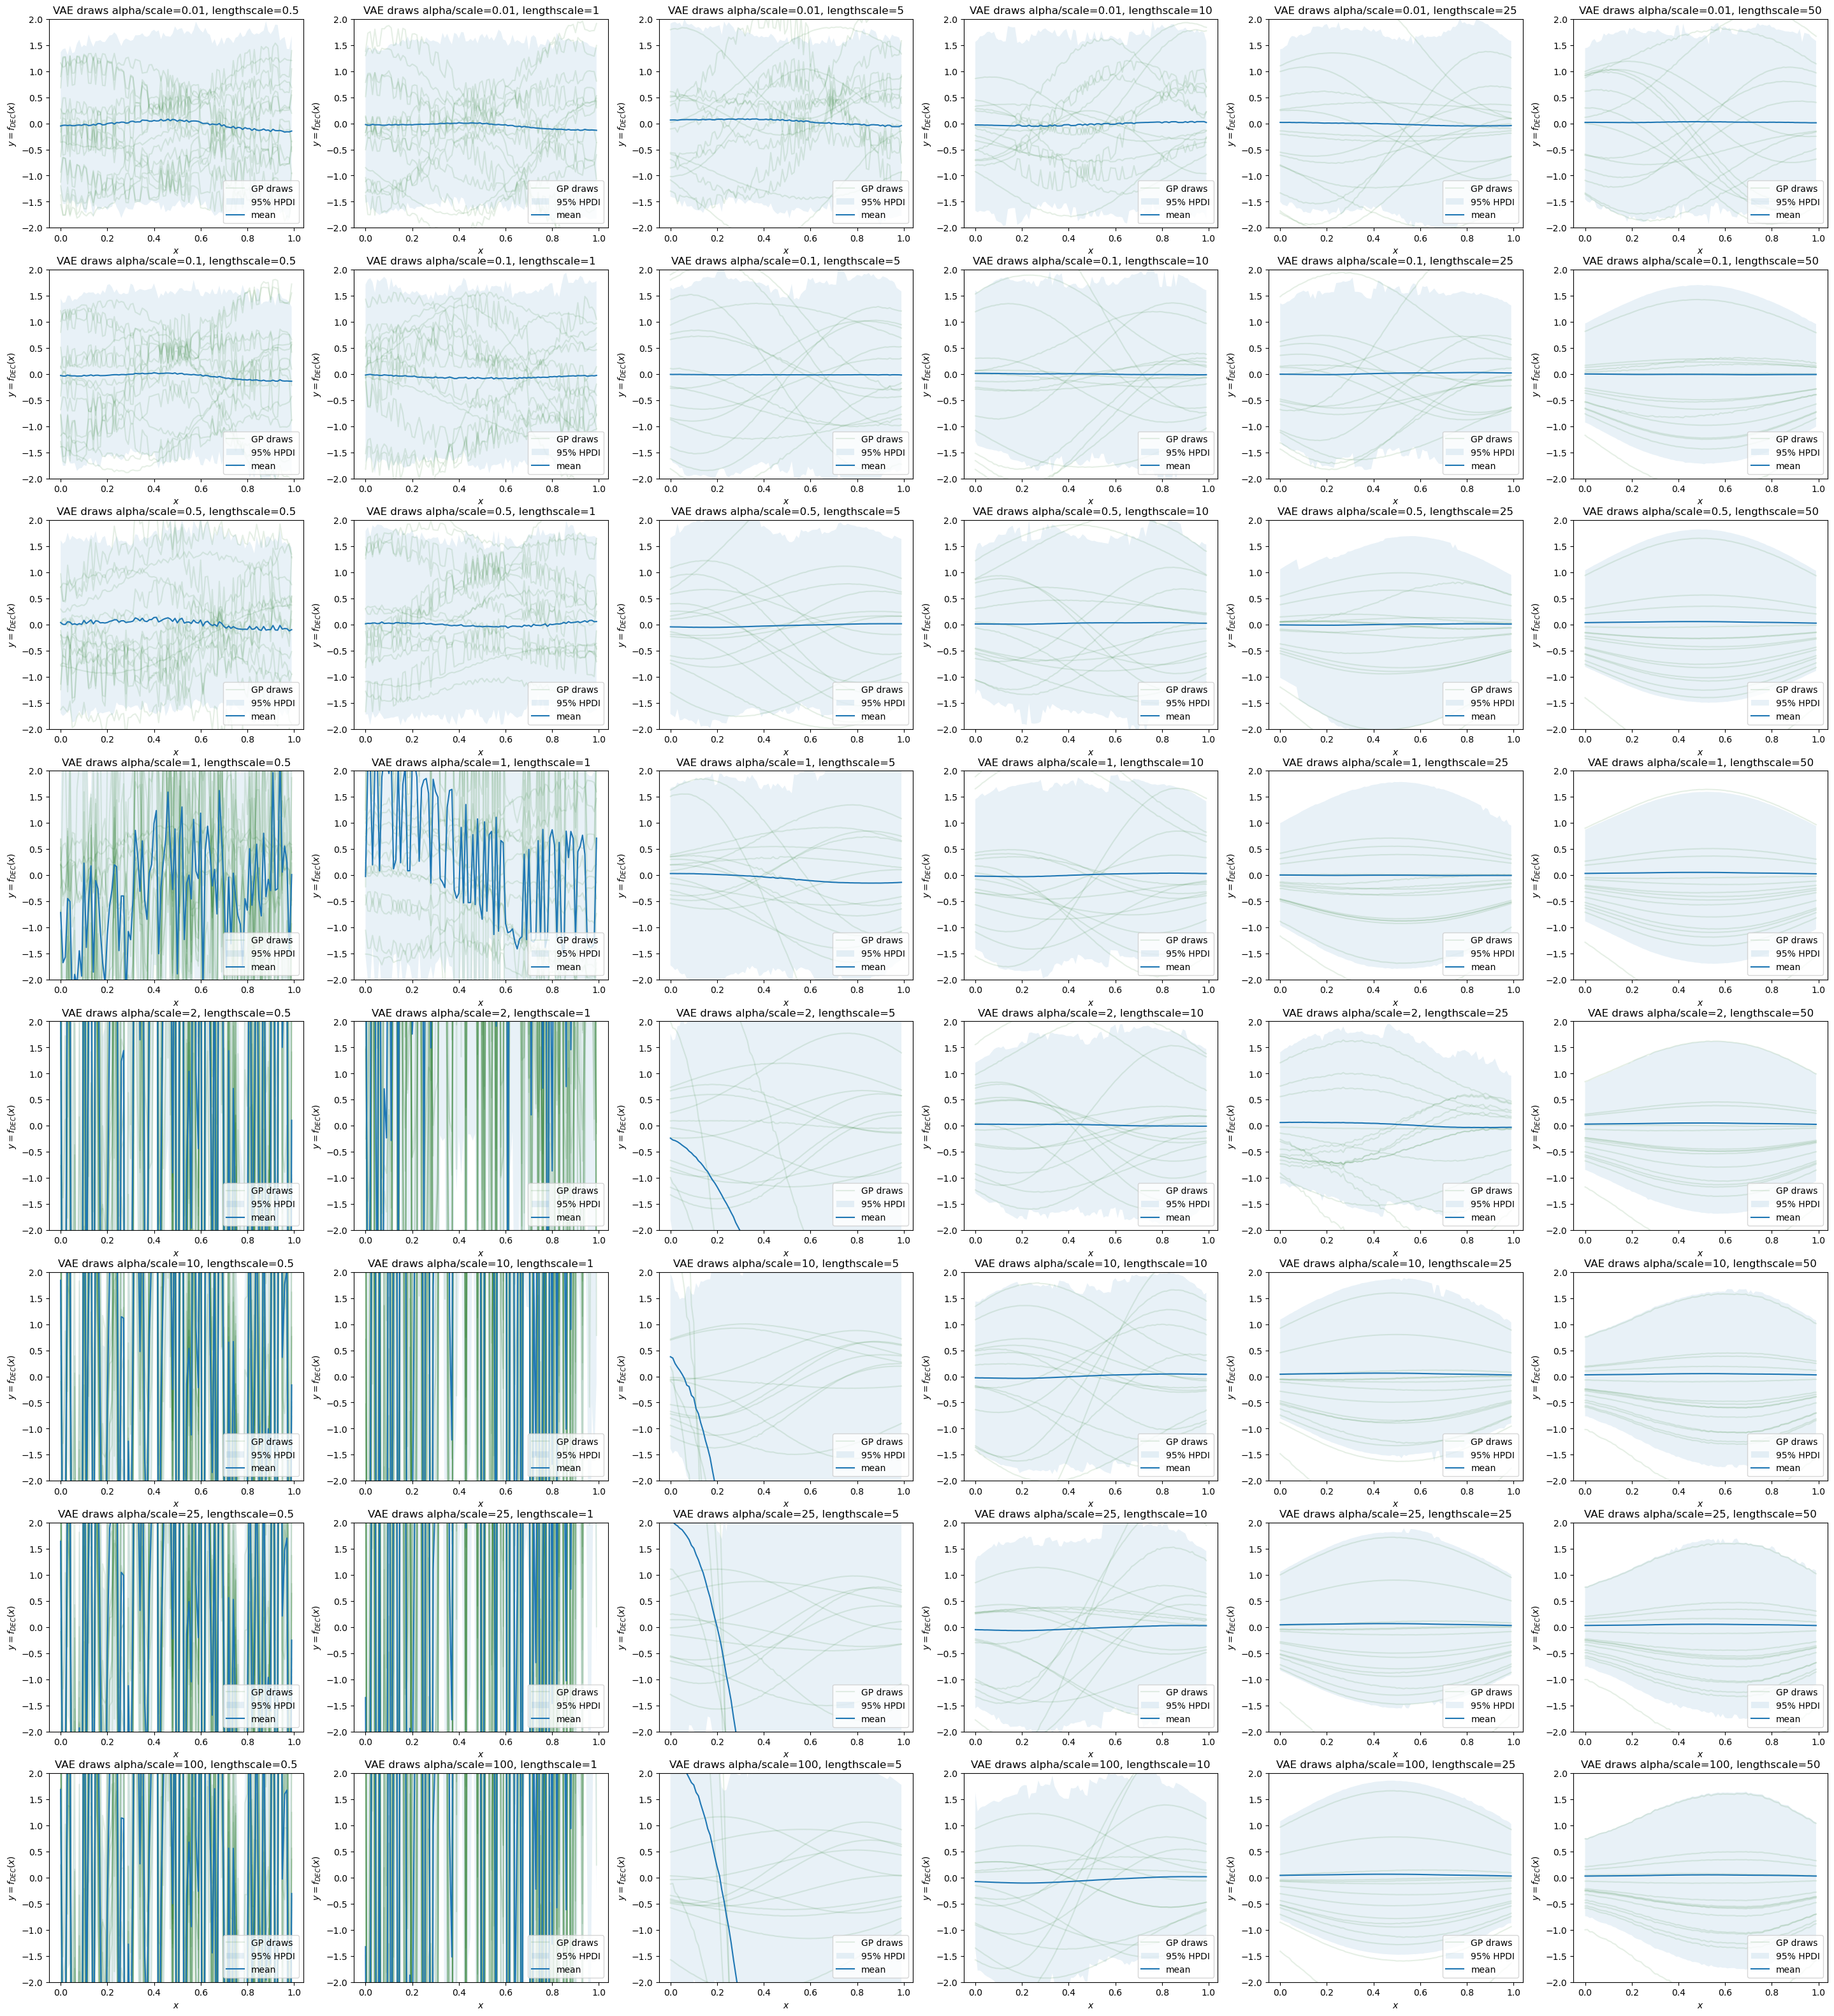

In [16]:
from reusable.vae import Single_Decoder
from reusable.vae import decoder_sample

plot_draws_hpdi(gp_draws, args["x"], "GP priors we want to encode",  '$y=f_{GP}(x)$')
print("Versus:")
training_fig, training_axs = plt.subplots(nrows=len(args["a_range"]), ncols=len(args["l_range"]), figsize=(len(args["l_range"]) * 6, len(args["a_range"]) * 5))

for i, a in enumerate(args["a_range"]):
    for j, l in enumerate(args["l_range"]):
        file_path = f'{get_savepath()}/{decoder_filename("09/09", args, suffix=name_fn(a,l))}'

        try:
            dummy_decoder = Single_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"] + args["n"],)))
            
            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(decoder_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(vae_draws, args["x"], f"VAE draws {a_label}={a}, {l_label}={l}", "$y=f_{DEC}(x)$", ax=training_axs[i, j])

        except FileNotFoundError:
            print(f"Failed to load a={a}, l={l}")

